In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch as th
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions.categorical import Categorical
import torch.nn as nn
import torch.optim as optim
import scipy.signal

from diffusion import *

In [3]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

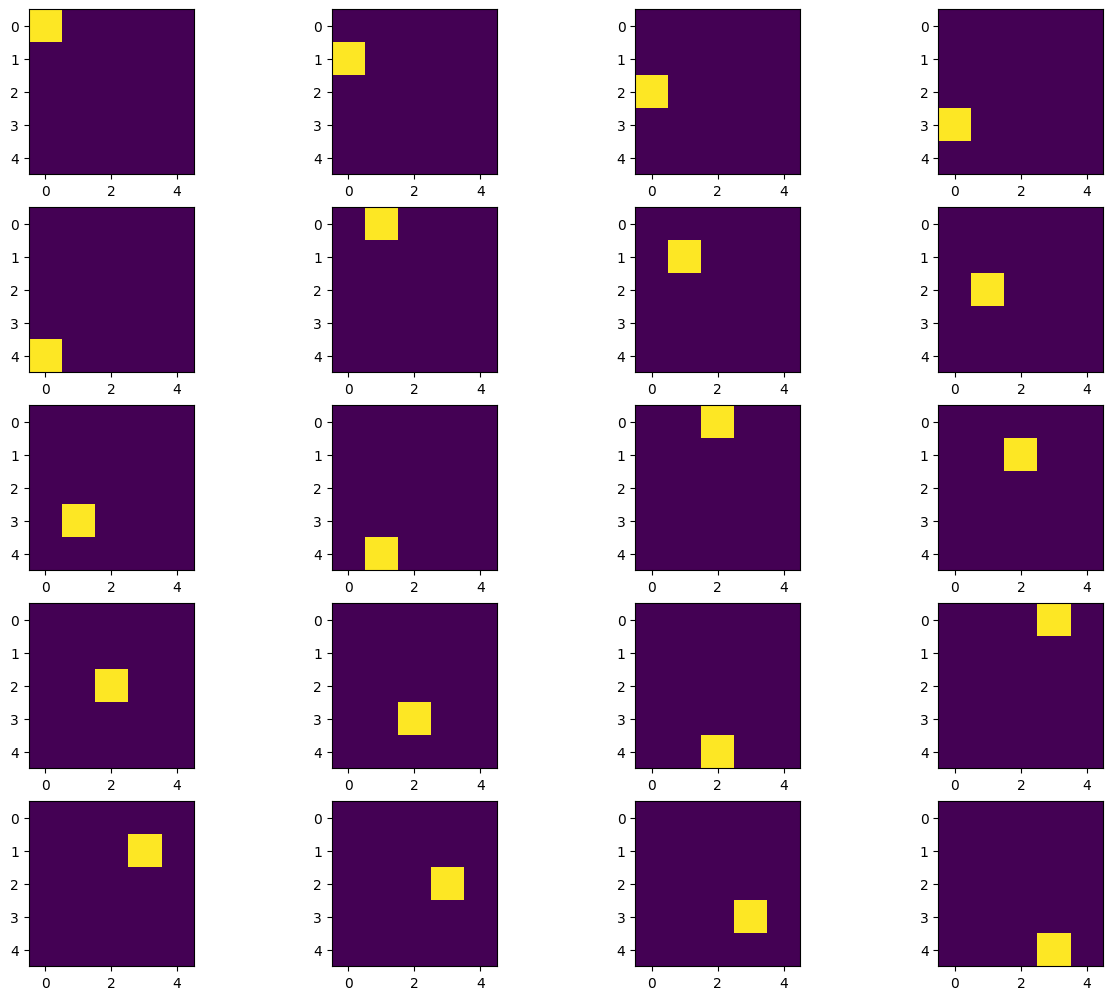

In [4]:
show_images(create_dataset(5, device))

In [9]:

loss_func = nn.CrossEntropyLoss()

model = nn.Sequential(
    nn.Conv2d(3, 64, 5, padding="same"),
    nn.ReLU(),
    nn.Conv2d(64, 64, 5, padding="same"),
    nn.ReLU(),
    nn.Conv2d(64, 64, 5, padding="same"),
    nn.ReLU(),
    nn.Conv2d(64, 2, 1, padding="same")
).to(device)
optimizer = optim.Adam(model.parameters(), lr=2.5e-4, eps=1e-5)

all_loss = []
all_simple_loss = []
all_path_loss = []

batch_size = 4

# dataset = create_dataset(5, device)
if False:
    for i in range(100):
        with th.no_grad():
            # sample trajectories
            last_x, xs, ts = sample_traj(model, batch_size, device, num=16)

            sum_p = 0
            target = 0
            for j in range(25):
                x0 = np.zeros((64, 2, 5, 5))
                x0[:, 1] = 1
                randx = j % 5
                randy = j // 5
                x0[:, 0, randx, randy] = 1
                x0[:, 1, randx, randy] = 0
                x0 =  th.tensor(x0, dtype=th.float32, device=device)

                p_x0 = th.sum(x0 * apply_qt(xs, ts), dim=(1), keepdim=True)
                p_x0 = th.prod(p_x0, dim=2, keepdim=True)
                p_x0 = th.prod(p_x0, dim=3, keepdim=True)
                sum_p = sum_p + p_x0
                target = target + p_x0 * x0
            target = target / sum_p

        
        for j in range(100):
            logits = calc_logits(model, xs, ts)
            path_loss = loss_func(logits, target)    
            all_path_loss.append(path_loss.item())

            loss = path_loss
            all_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
else:
    for i in range(3000):
        # simple loss
        batch_size = 128
        x0 = create_data(batch_size, 5, device)
        ts = np.exp(np.random.uniform(-2, 0, size=(batch_size, 1, 1, 1))*np.log(10))
        ts = th.tensor(ts, dtype=th.float32, device=device)
        xt = sample(apply_qt(x0, ts))
        ts = th.zeros_like(xt[:,0:1]) + ts
        logits = calc_logits(model, xt, ts)
        simple_loss = loss_func(logits, x0)
        all_simple_loss.append(simple_loss.item())

        loss = simple_loss
        all_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    

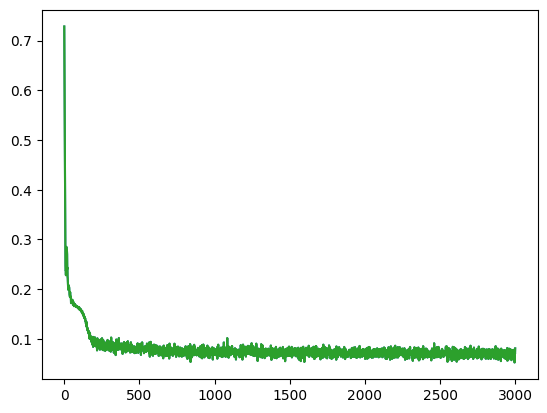

In [10]:

sigma = 1
gx = np.linspace(-3*sigma, 3*sigma, 1)
gaussian = np.exp(-(gx/sigma)**2/2)
res = np.convolve(all_loss, gaussian, mode="full")


# plt.plot(all_loss)
plt.plot(all_loss)
plt.plot(all_path_loss) 
plt.plot(all_simple_loss)
plt.show()

    


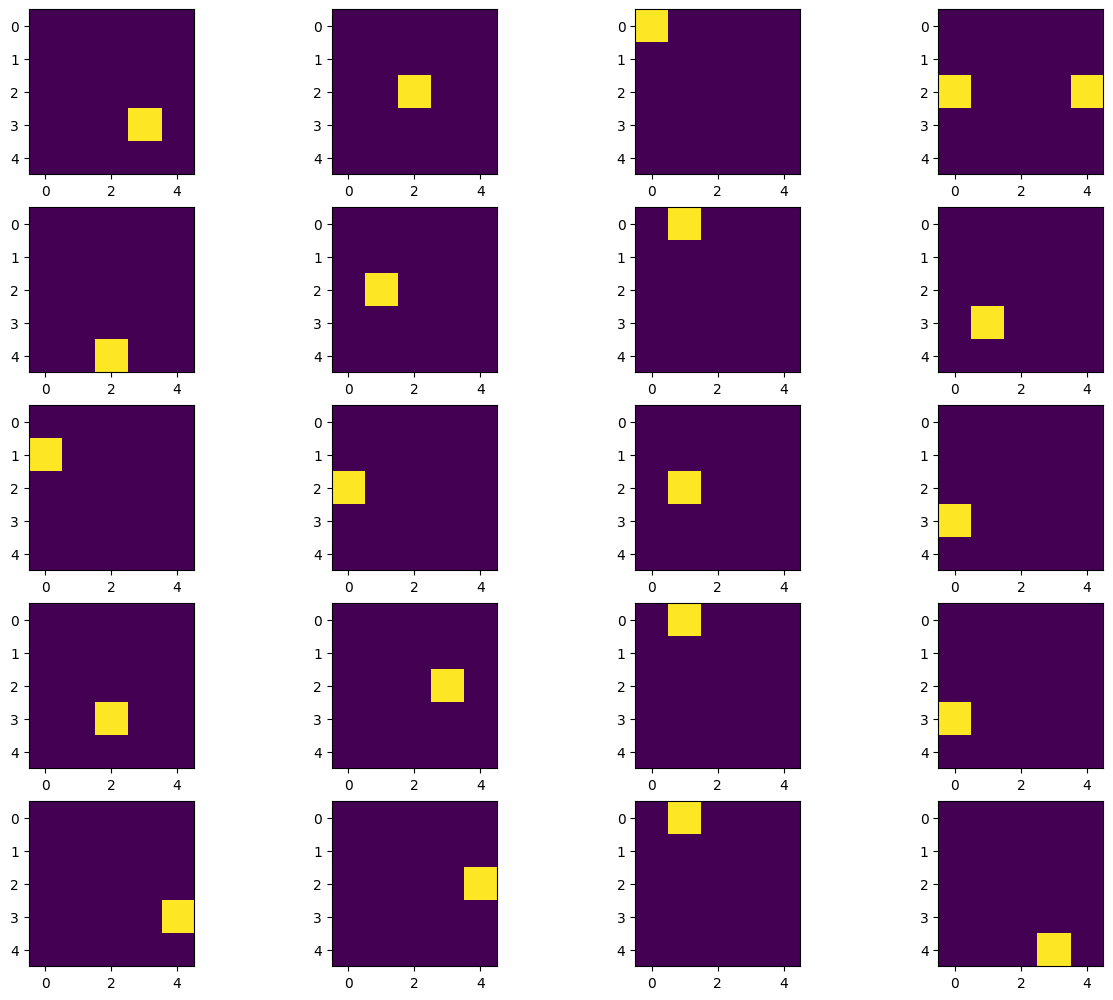

In [14]:
last_x, xs, ts = sample_traj(model, 20, device, 500)
show_images(last_x)

In [345]:
(all_x,
        all_prob,
        all_new_x_prob,
        all_sum,
        all_xdt,
        all_probsdt,
        all_x,
        all_t_inp) = sample_traj_full(model, 8, device, 200)

In [346]:

xs = all_x[:,0]
ts = all_t_inp[:,0]

sum_p = 0
target = 0
for j in range(25):
    x0 = np.zeros((16, 2, 5, 5))
    x0[:, 1] = 1
    randx = j % 5
    randy = j // 5
    x0[:, 0, randx, randy] = 1
    x0[:, 1, randx, randy] = 0
    x0 =  th.tensor(x0, dtype=th.float32, device=device)

    p_x0 = th.sum(x0 * apply_qt(xs, ts), dim=(1), keepdim=True)
    p_x0 = th.prod(p_x0, dim=2, keepdim=True)
    p_x0 = th.prod(p_x0, dim=3, keepdim=True)
    sum_p = sum_p + p_x0
    target = target + p_x0 * x0
target = target / sum_p
print(th.mean(target[:,0], dim=(1,2)))
show_images(target, vmin=0, vmax=1)

RuntimeError: The size of tensor a (16) must match the size of tensor b (200) at non-singleton dimension 0

torch.Size([16, 8, 2, 5, 5])


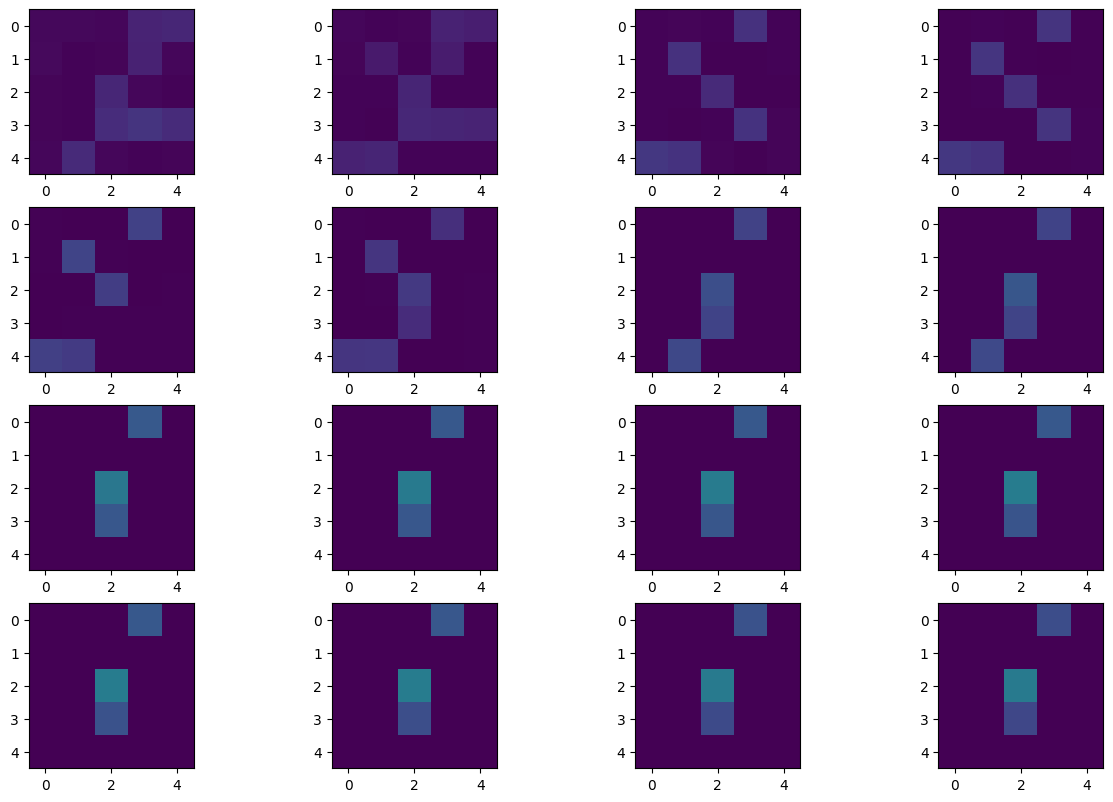

In [ ]:
print(all_prob.shape)
# show_images(all_x[::,0], vmin=0, vmax=1)
# print(th.mean(all_prob[:,:,0], dim=(1,2)))
show_images(all_prob[::,0], vmin=0, vmax=1)

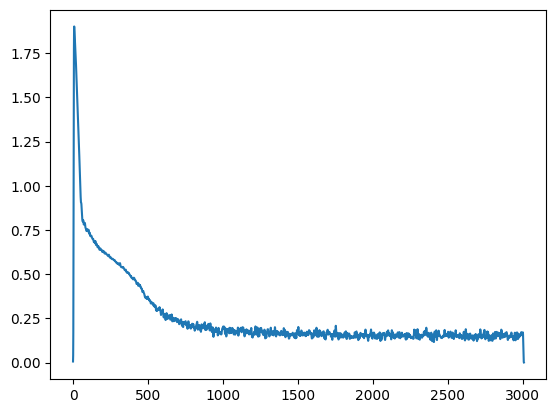

In [161]:
xt0 = xt

In [162]:
dt = 0.01
all_t = np.arange(0, 1, dt)
all_t = np.logspace(-4, np.log10(1), num=500)
print(np.min(all_t), np.max(all_t))
print(len(all_t))

# xt = xt0[0:1]
xt = sample(th.ones(8, 2, 5, 5).to(device)/2)
cur_x = xt
new_x = xt

all_x = []
all_prob = []
all_new_x_prob = []

all_sum = []
all_xdt = []
all_probsdt = []

for i, t in list(reversed(list(enumerate(all_t[1:])))):
    dt = all_t[i+1]-all_t[i]
    # print(dt)
    t_inp = cur_x[:,0:1] *0 + t
    cur_x = new_x
    print(t)

    logits = model(th.concat((cur_x, th.log(t_inp)), dim=1))
    probs = th.exp(logits)/th.sum(th.exp(logits), dim=1, keepdim=True)

    # print(probs.shape, apply_qt(cur_x, ts).shape)
    new_x_probs = probs*0
    for x0 in all_x0:
        p_x0 = th.sum(probs*x0, dim=1, keepdims=True)
        sum = th.sum(x0*apply_qt(cur_x, t_inp*0+t), dim=1, keepdim=True)
        # print(th.mean(t_inp*0+dt).item(),th.mean(t_inp*0+t-dt).item())
        new_x_probs = new_x_probs + p_x0*(apply_qt(cur_x, t_inp*0+dt) * apply_qt(x0, t_inp*0+t-dt))/sum
    new_x = sample(new_x_probs)

    # plt.imshow(cur_x.detach().cpu().numpy()[0,0])µ
    # plt.show()
    # plt.imshow(probs.detach().cpu().numpy()[0,0], vmin=0, vmax=1)
    # plt.show()

    all_x.append(cur_x)
    all_prob.append(probs)
    all_new_x_prob.append(new_x_probs)

    all_sum.append(sum)
    all_xdt.append(apply_qt(cur_x, t_inp*0+dt))
    all_probsdt.append(apply_qt(probs, t_inp*0+t-dt))


all_x = th.stack(all_x, dim=0)
all_prob = th.stack(all_prob, dim=0)
all_new_x_prob = th.stack(all_new_x_prob, dim=0)
all_sum = th.stack(all_sum, dim=0)
all_xdt = th.stack(all_xdt, dim=0)
all_probsdt = th.stack(all_probsdt, dim=0)
    

0.0001 1.0
500
1.0
0.9817117022752183
0.9637578663841079
0.9461323755890759
0.928829225017249
0.9118425196146562
0.8951664721378292
0.8787954011821311
0.8627237292461442
0.8469459808314577
0.8314567805772055
0.816250851428722
0.8013230128396879
0.7866681790071582
0.7722813571388643
0.758157645752211
0.7442922330043759
0.73068039505295
0.7173174944465612
0.7041989785449289
0.6913203779678128
0.6786773050723295
0.666265452458115
0.6540805914998252
0.6421185709064758
0.6303753153071275
0.6188468238624383
0.6075291689016071
0.596418494584246
0.5855110155867238
0.5748030158125351
0.5642908471262537
0.5539709281106401
0.5438397428464796
0.533893839714735
0.5241298302206057
0.5145443878390924
0.5051342468816761
0.49589620138372115
0.4868271040122279
0.4779238649935595
0.4691834510607794
0.46060288442023983
0.45217924173706975
0.44390965313921665
0.43579130123970256
0.4278214201767613
0.4199972946715302
0.4123162591029748
0.4047756965997318
0.39737303814856045
0.39010576171909894
0.38297139140

tensor(0.0800, device='cuda:0', grad_fn=<MeanBackward0>)


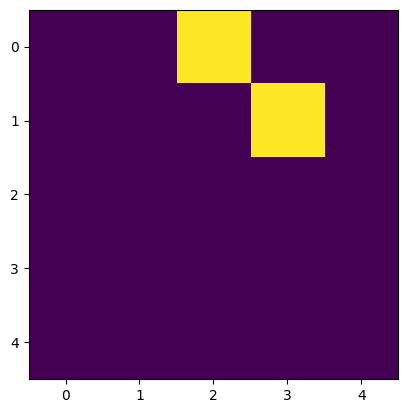

In [163]:
print(th.mean(all_new_x_prob[-1][4,0]))

plt.imshow(all_new_x_prob[-1][4,0].detach().cpu().numpy(), vmin=0, vmax=1)
plt.show()

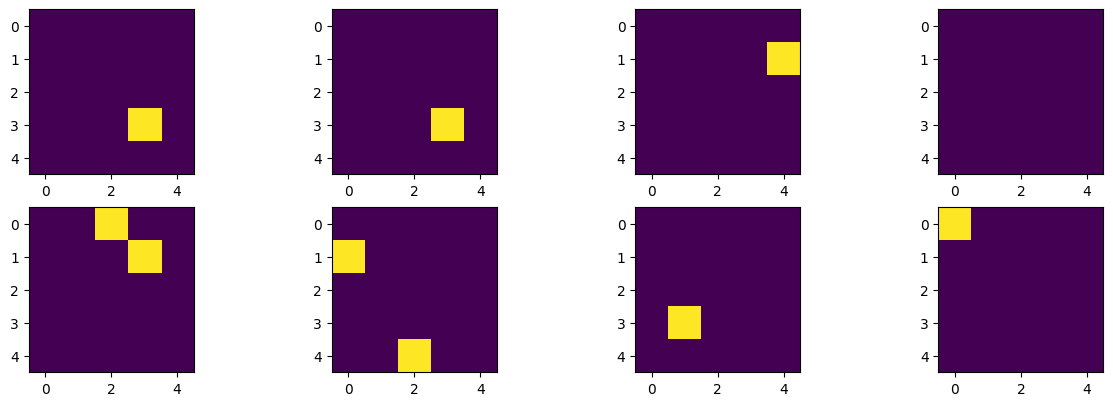

In [164]:
# for x in all_x[::10]:
#     plt.imshow(x[0,0].detach().cpu().numpy())
#     plt.show()

# print(all_x.shape)
show_images(all_x[-1])
# show_images(all_prob[8::10], vmin=0, vmax=1)
# show_images(all_new_x_prob[8::10], vmin=0, vmax=1)

tensor([0.0174, 0.0389, 0.0778, 0.1025, 0.0778], device='cuda:0',
       grad_fn=<MeanBackward1>)


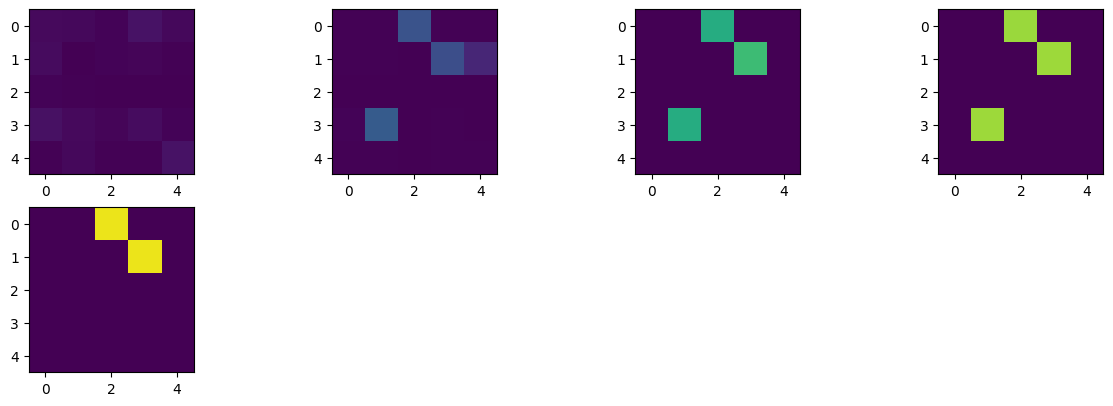

In [168]:

id_to_print = 4
# print(all_prob[8::100,id_to_print,0,2,4])
print(th.mean(all_prob[8::100,id_to_print,0], dim=(1,2)))
show_images(all_prob[8::100,id_to_print], vmin=0, vmax=1)

# Computing the probability of xt knowing x0

In [ ]:
x0 = create_data(batch_size, 5, device)
xt = 
t = 

pxt = x0 * 

torch.Size([49, 2, 5, 5])


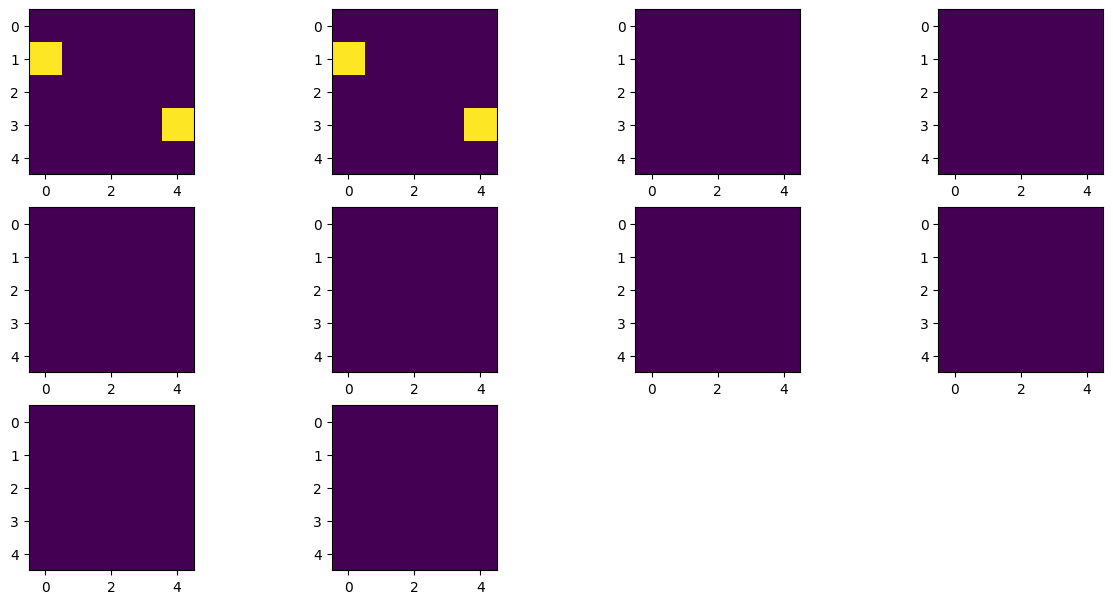

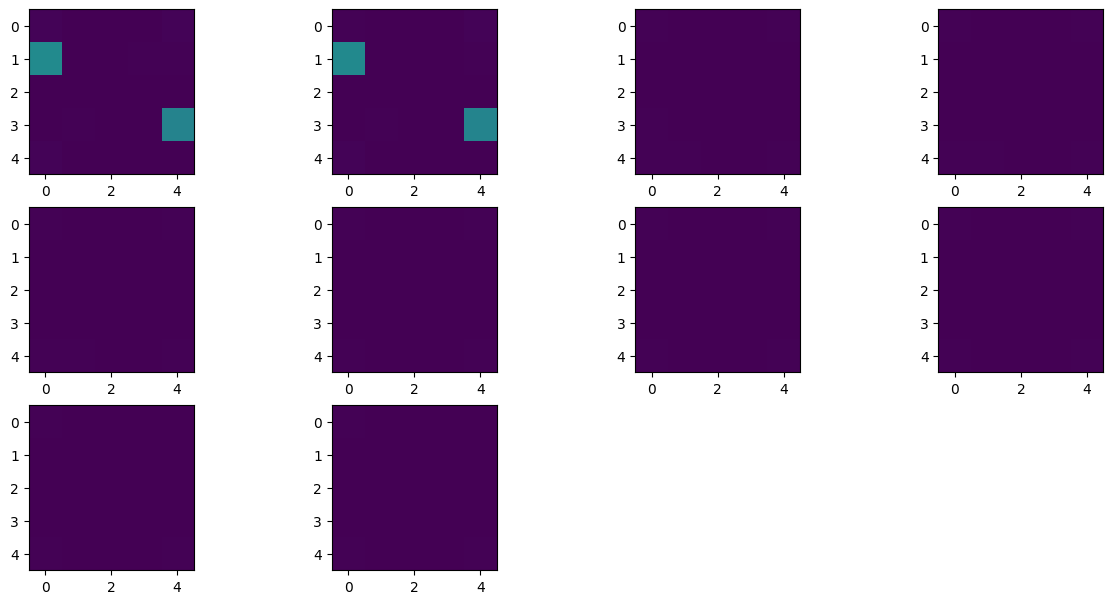

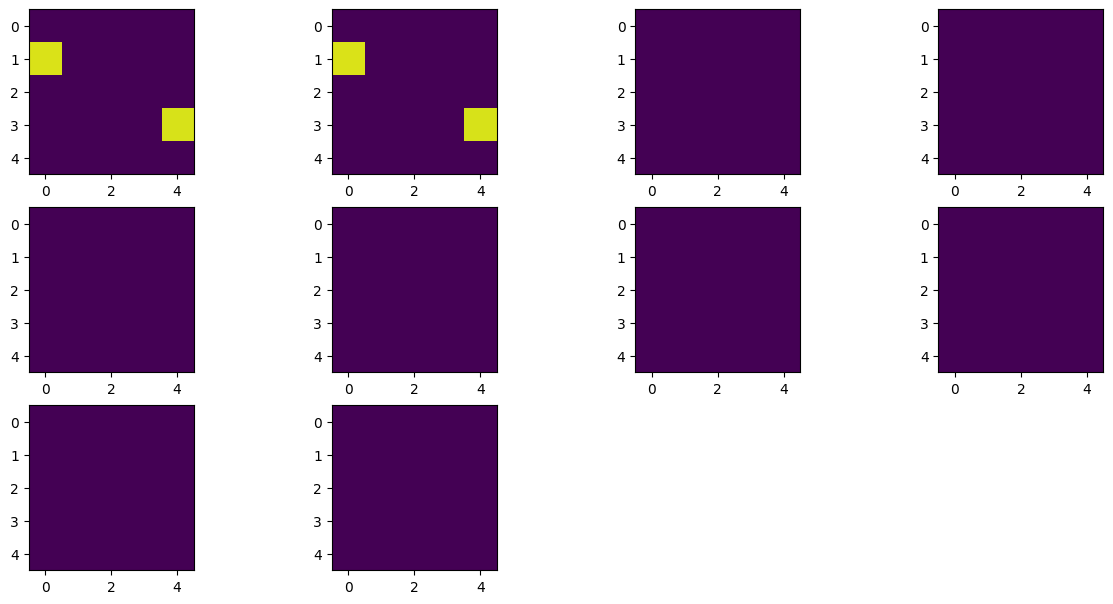

# End of notebook

In [39]:
print(all_sum[28])

tensor([[[0.9391, 0.9424, 0.9443, 0.9418, 0.9390],
         [0.2481, 0.9446, 0.9448, 0.9428, 0.9430],
         [0.9431, 0.9447, 0.9455, 0.9442, 0.4184],
         [0.3045, 0.9419, 0.9445, 0.9428, 0.2621],
         [0.9417, 0.9430, 0.9433, 0.9445, 0.9431]]], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [47]:
dt = 0.01
all_t = np.arange(0, 1, dt)
# all_t = np.logspace(-2, 0)
print(len(all_t))

xt = xt0[0:1]
cur_x = xt
new_x = xt

all_x = []
all_prob = []

for i, t in list(reversed(list(enumerate(all_t[1:])))):
    dt = all_t[i+1]-all_t[i]
    t_inp = cur_x[:,0:1] *0 + t
    cur_x = new_x

    logits = model(th.concat((cur_x, t_inp), dim=1))
    probs = th.exp(logits)/th.sum(th.exp(logits), dim=1, keepdim=True)
    x0 = sample(probs)
    new_x = sample(apply_qt(x0, cur_x[:,0:1] *0 + all_t[i]))

    # plt.imshow(cur_x.detach().cpu().numpy()[0,0])µ
    # plt.show()
    # plt.imshow(probs.detach().cpu().numpy()[0,0], vmin=0, vmax=1)
    # plt.show()

    all_x.append(cur_x)
    all_prob.append(probs)
all_x = th.concat(all_x, dim=0)
all_prob = th.concat(all_prob, dim=0)
    

100


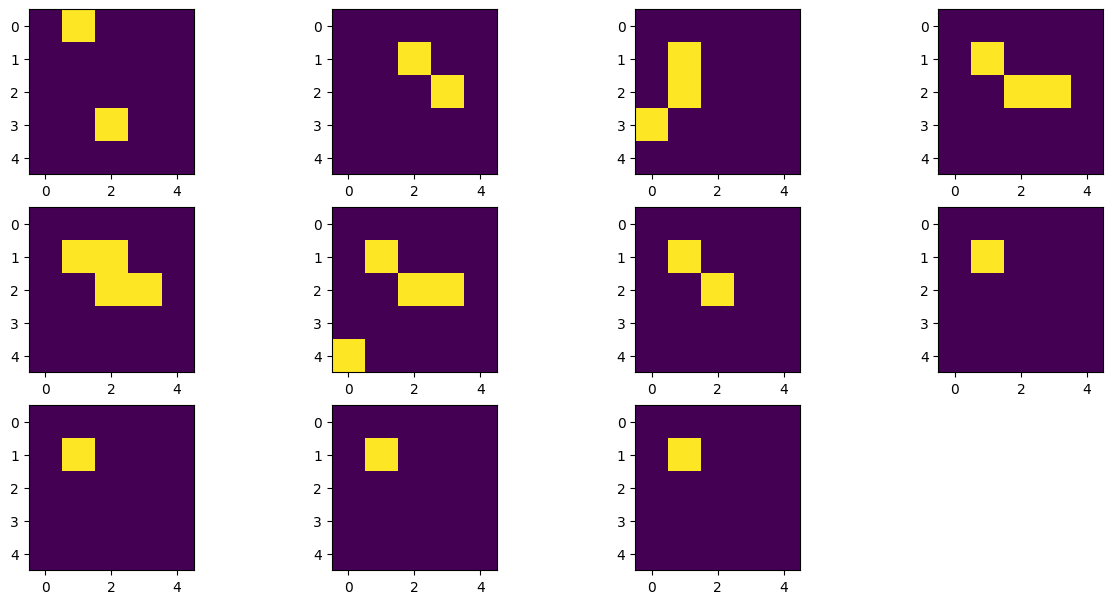

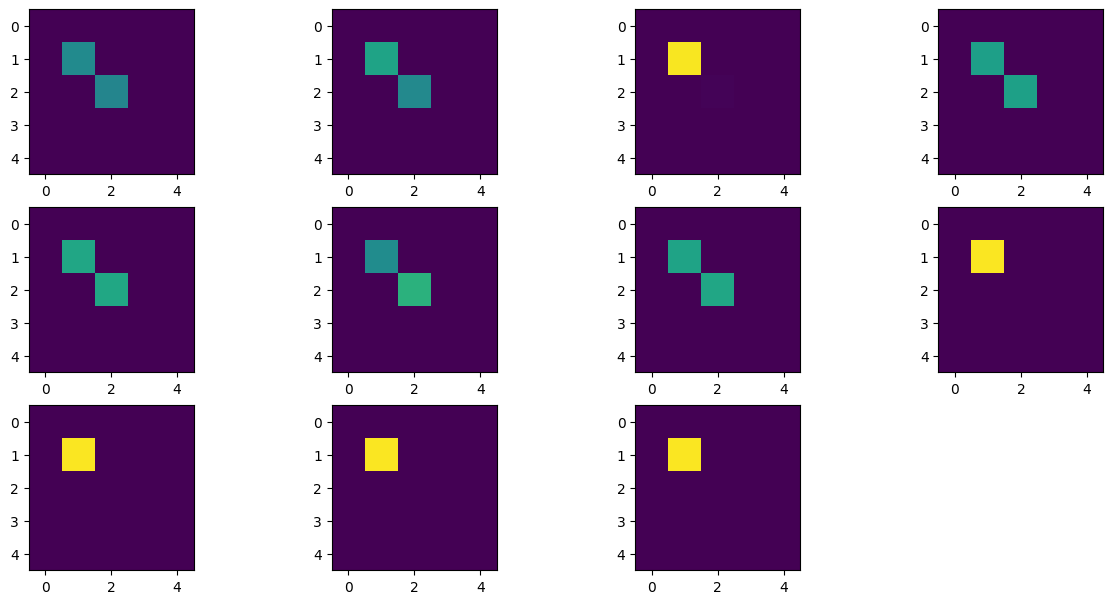

In [48]:

show_images(all_x[88:])
show_images(all_prob[88:], vmin=0, vmax=1)
# plt.show()

In [48]:

show_images(all_x[88:])
show_images(all_prob[88:], vmin=0, vmax=1)
show_images(all_new_x_prob[88:], vmin=0, vmax=1)

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>